Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance Segmentation of Powder Particles and Satellites

This example will take you through the process of training a model to segment powder particles and visualizing the model predictions.

In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode

## ampis
root = '../../../'
ocean_images = root + '../../../../ocean/projects/dmr200021p/sprice/initial_paper_complete_set/'
ocean_syn = root + '../../../../ocean/projects/dmr200021p/sprice/synthetic_training/'
sys.path.append(root)


from ampis import data_utils, visualize, export_anno

%matplotlib inline

# Labeling Data

The [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/) was used to generate particle labels. The a

# Loading Data
The process for training models for powder particles and satellites is identical. Enter the corresponding value depending on which model you want to train. <br />
The paths to individual images, and all annotation data are stored in the JSON files generated by the VGG image annotator.



In [19]:
EXPERIMENT_NAME = 'satellite' # can be 'particle' or 'satellite'
EXPERIMENT_NUM = '5'
'''json_path_train = Path('training_sets', f'{EXPERIMENT_NAME}_auto_training_v1.7.json')  # path to training data
json_path_val = Path('training_sets',f'{EXPERIMENT_NAME}_auto_validation_v1.1.json')  # path to training data
assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'''

"json_path_train = Path('training_sets', f'{EXPERIMENT_NAME}_auto_training_v1.7.json')  # path to training data\njson_path_val = Path('training_sets',f'{EXPERIMENT_NAME}_auto_validation_v1.1.json')  # path to training data\nassert json_path_train.is_file(), 'training file not found!'\nassert json_path_val.is_file(), 'validation file not found!"

## Registration
Detectron2 requires that datasets be registered for later use.
Registration stores the name of the dataset and a function that can be used to retrieve the image paths and labels in a format that the model can use.

## Model Configuration
This is where we specify the directory where the outputs are saved, various hyperparameters for the model, and more.

In [20]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.SOLVER.IMS_PER_BATCH = 1 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 250  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 5000  # maximum number of iterations to run during training
                            # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

weights_path = Path(str(root),'examples','powder','satellite_output_auto','model_final_W3.6.pth')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
#cfg.OUTPUT_DIR = str(Path(ocean_syn, 'Models', f'Synthetic_training_a1.{EXPERIMENT_NUM}'))
cfg.OUTPUT_DIR = str(Path(ocean_syn, 'Models', f'Synthetic_training_AMPIS1.{EXPERIMENT_NUM}'))
# make the output directory
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
print(str(model_checkpoints[-1]))
predictor = DefaultPredictor(cfg)  # create predictor object

Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_final.pth


In [21]:
#path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
#t = ['particles1', 'particles10','particles11']
t = ['Sc2Tile_003-001-000_0-000', 'Sc2Tile_010-006-000_0-000','Sc3Tile_010-001-000_0-000']
path = ocean_syn + 'images/AMPIS_dataset/renders'
results = []  
count = 0
extension = ['999', '1999', '2999', '3999', '4999', '5999', '6999', '7999', '8999', '9999', '10999', '11999', '12999', '13999', '14999']
for i in range(0, len(model_checkpoints) - 1):
    cfg.MODEL.WEIGHTS = str(model_checkpoints[i])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
    print(str(model_checkpoints[i]))
    predictor = DefaultPredictor(cfg)  # create predictor object
    for f in t:
        print("Annotating: " + f)
        img_path = Path(path, f +'.png')
        img = cv2.imread(str(img_path))
        outs = predictor(img)
        results.append(data_utils.format_outputs(img_path, 'Validation', outs))
        #visualize.display_ddicts(ddict=outs,  # predictions to display
                                 #outpath=None, dataset='Test',  # don't save fi$
                                 #gt=False,  # specifies format as model predict$
                                 #img_path=img_path, # path to image
                                 #suppress_labels=True, #hides class images
                                 #summary=True)  #hides the end print statement        
    
    # save to disk
    #with open(Path('Model_Performances', f'{EXPERIMENT_NAME}-model_a1.{EXPERIMENT_NUM}.pickle'), 'wb') as f:
    with open(Path('Model_Performances', 'Training_6_image_ampis', f'{EXPERIMENT_NAME}-model_AMPIS1.{EXPERIMENT_NUM}_section_{extension[i]}.pickle'), 'wb') as f:
        pickle.dump(results, f)
    count += 1

../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_0000999.pth
Annotating: Sc2Tile_003-001-000_0-000
Annotating: Sc2Tile_010-006-000_0-000
Annotating: Sc3Tile_010-001-000_0-000
../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_0001999.pth
Annotating: Sc2Tile_003-001-000_0-000
Annotating: Sc2Tile_010-006-000_0-000
Annotating: Sc3Tile_010-001-000_0-000
../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_0002999.pth
Annotating: Sc2Tile_003-001-000_0-000
Annotating: Sc2Tile_010-006-000_0-000
Annotating: Sc3Tile_010-001-000_0-000
../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_0003999.pth
Annotating: Sc2Tile_003-001-000_0-000
Annotating: Sc2Tile_010-006-000_0-000
Annotating: Sc3Tile_010-001-000_0-000
../../../../../../../ocean/projects/dmr2

## Generating predictions on new images is simple.
We will load a new image (not included in either dataset) and generate predictions.
Note that we do not have labels for this image and do not need to register it to a dataset.

In [4]:
img_path = Path('Auto_annotate_images','S01_02_SE1_300X06.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image


AttributeError: 'NoneType' object has no attribute 'shape'

We will now generate predictions on all of the images in the training and validation sets, and save the results for later.

../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_final.pth
Annotating: Sc2Tile_003-001-000_0-000


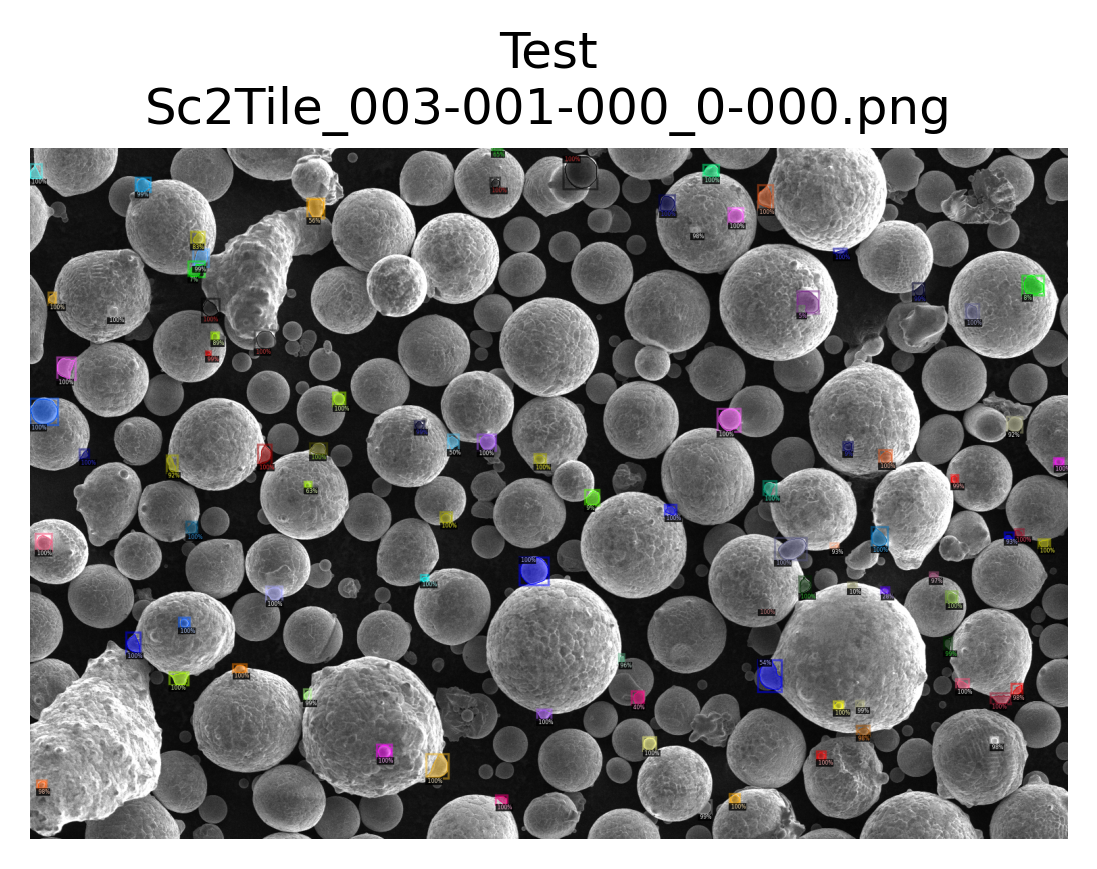

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc2Tile_003-001-000_0-000.png
	num_instances: 89
Annotating: Sc2Tile_010-006-000_0-000


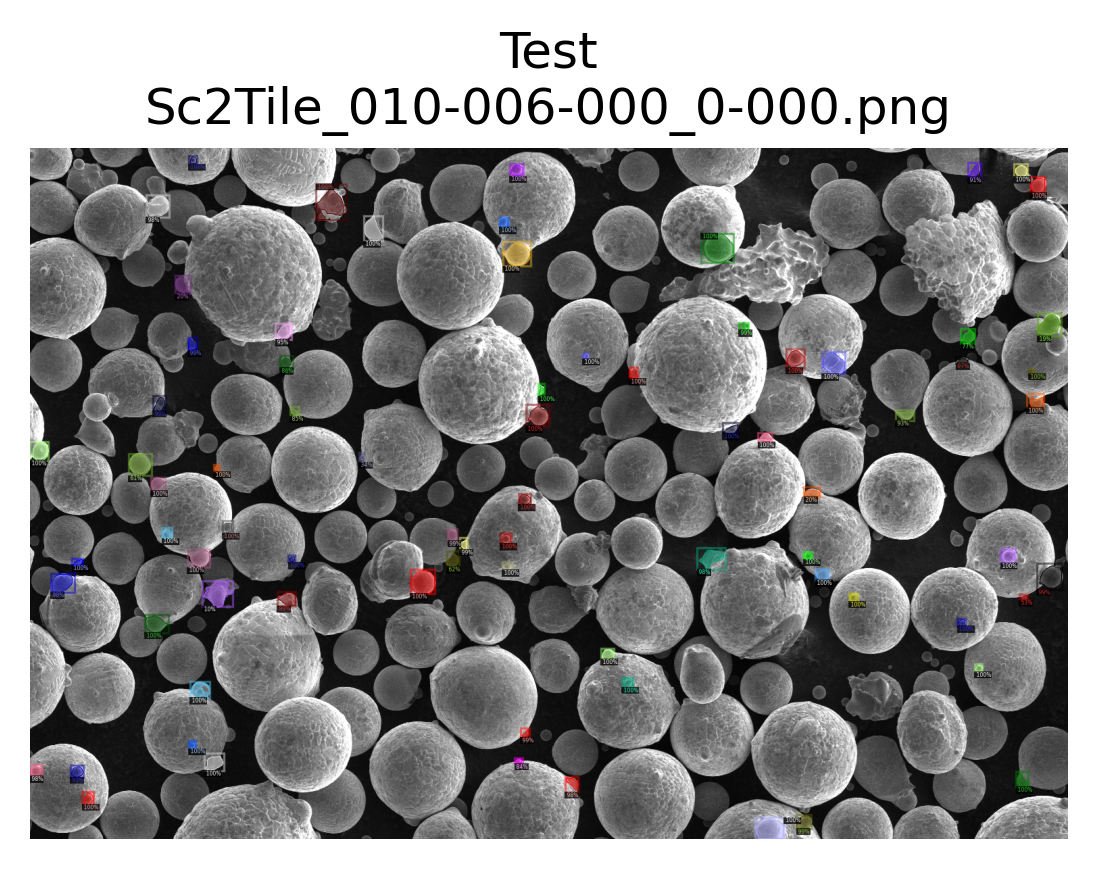

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc2Tile_010-006-000_0-000.png
	num_instances: 77
Annotating: Sc3Tile_010-001-000_0-000


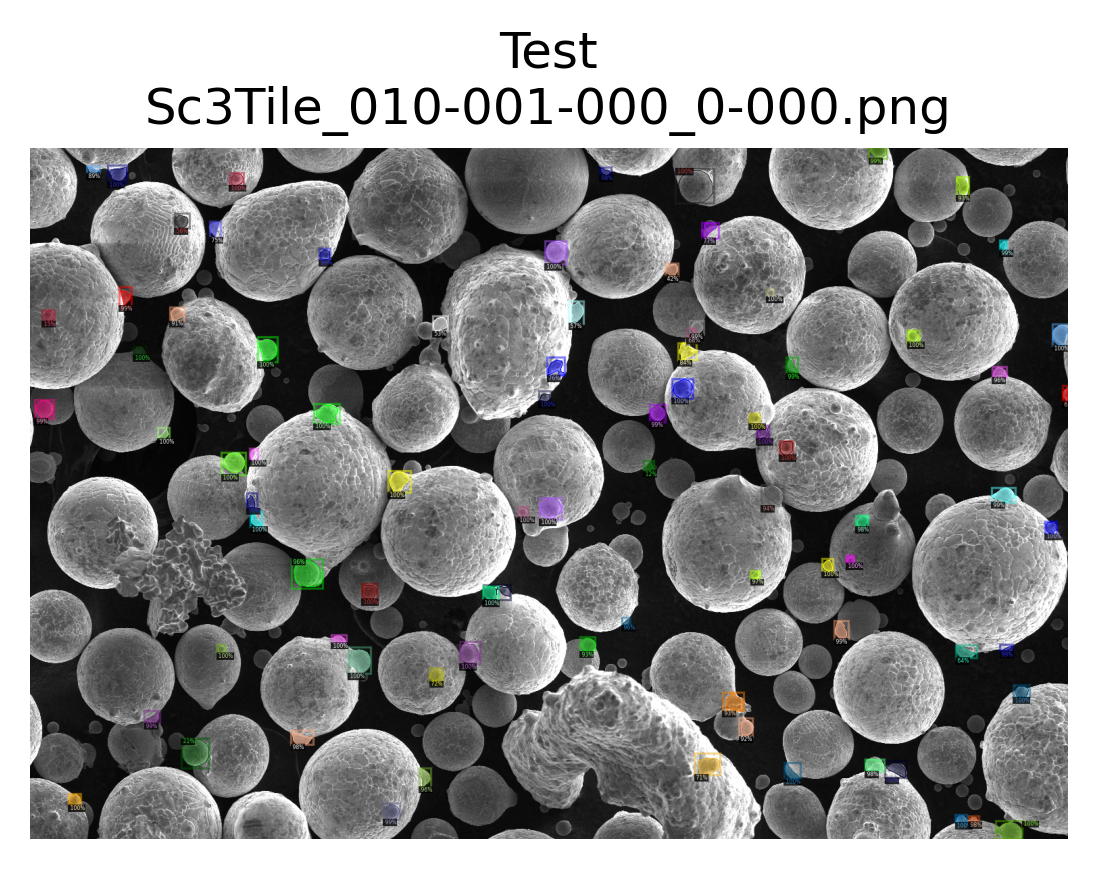

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc3Tile_010-001-000_0-000.png
	num_instances: 85
../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/Models/Synthetic_training_AMPIS1.5/model_0006999.pth
Annotating: Sc2Tile_003-001-000_0-000


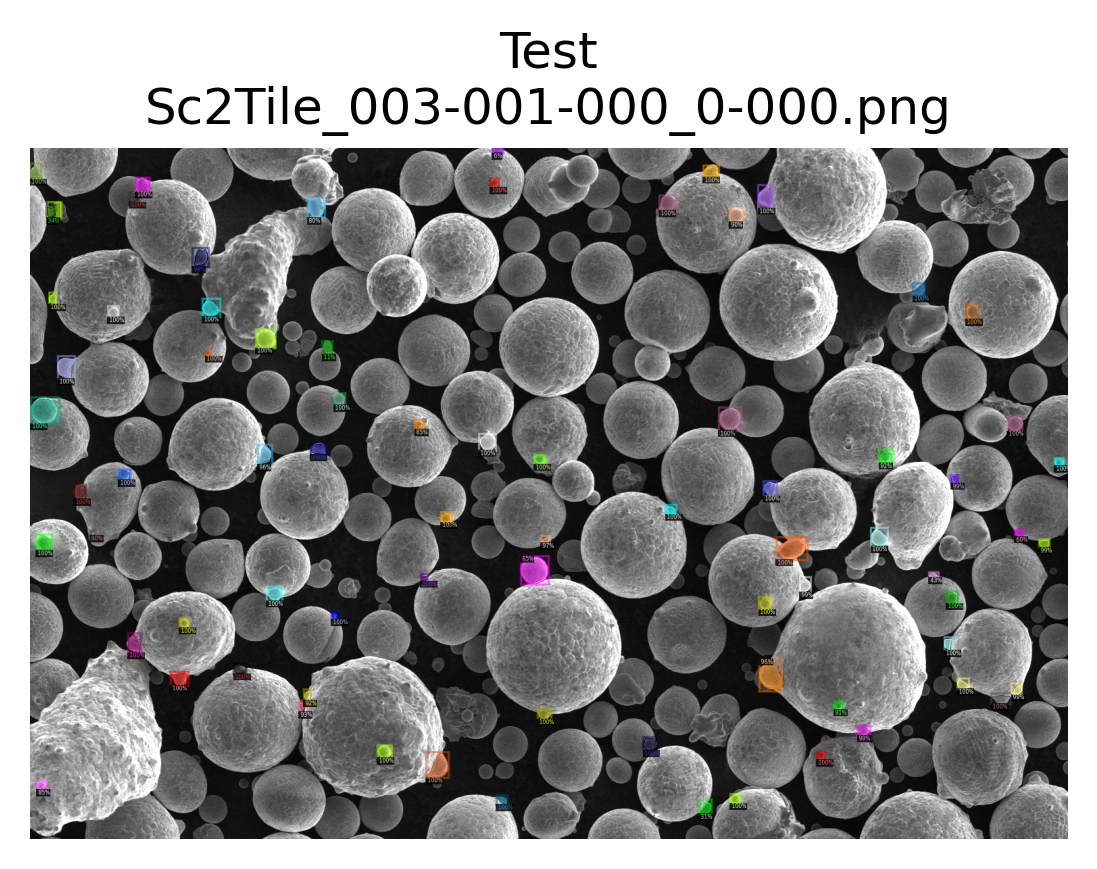

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc2Tile_003-001-000_0-000.png
	num_instances: 76
Annotating: Sc2Tile_010-006-000_0-000


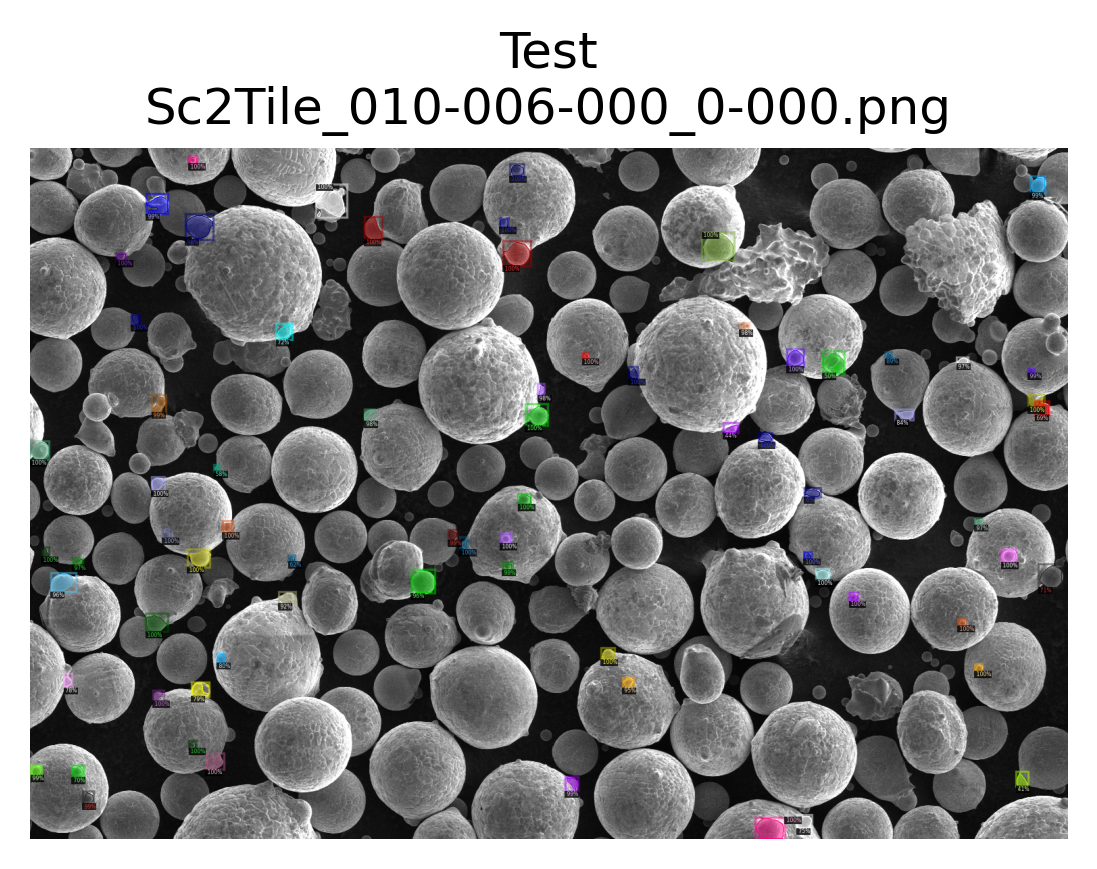

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc2Tile_010-006-000_0-000.png
	num_instances: 72
Annotating: Sc3Tile_010-001-000_0-000


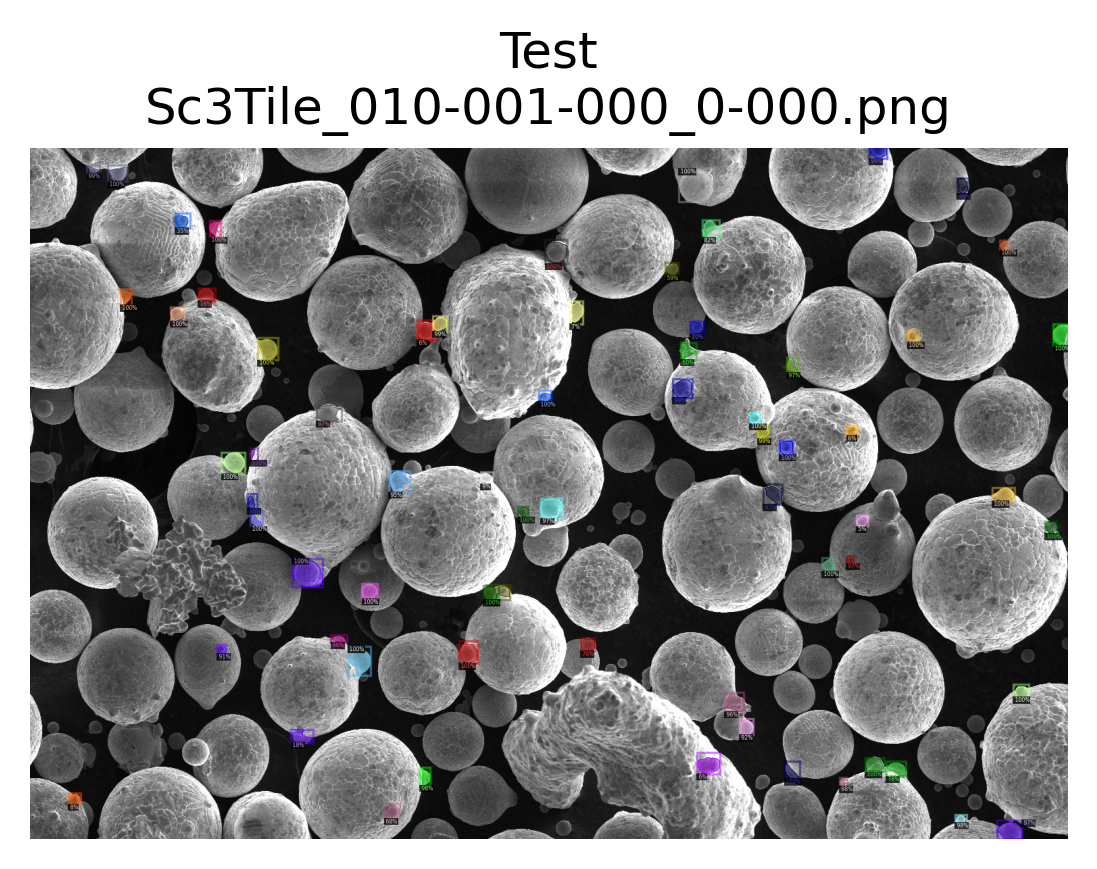

ddict info:
	path: ../../../../../../../ocean/projects/dmr200021p/sprice/synthetic_training/images/AMPIS_dataset/renders/Sc3Tile_010-001-000_0-000.png
	num_instances: 67


In [24]:
#path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
#t = ['particles1', 'particles10','particles11']
t = ['Sc2Tile_003-001-000_0-000', 'Sc2Tile_010-006-000_0-000','Sc3Tile_010-001-000_0-000']
path = ocean_syn + 'images/AMPIS_dataset/renders'
results = []  
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
print(str(model_checkpoints[-1]))
predictor = DefaultPredictor(cfg)  # create predictor object
for f in t:
    print("Annotating: " + f)
    img_path = Path(path, f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    results.append(data_utils.format_outputs(img_path, 'Validation', outs))
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement        

    
cfg.MODEL.WEIGHTS = str(model_checkpoints[-5])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
print(str(model_checkpoints[-10]))
predictor = DefaultPredictor(cfg)  # create predictor object
for f in t:
    print("Annotating: " + f)
    img_path = Path(path, f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    results.append(data_utils.format_outputs(img_path, 'Validation', outs))
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement  
    
    
    
# save to disk
#with open(Path('Model_Performances', f'{EXPERIMENT_NAME}-model_a1.{EXPERIMENT_NUM}.pickle'), 'wb') as f:
#with open(Path('Model_Performances', f'{EXPERIMENT_NAME}-model_AMPIS1.{EXPERIMENT_NUM}.pickle'), 'wb') as f:
    #pickle.dump(results, f)



In [9]:
path = ocean_syn + 'images/a-lognormal-loc0.1-shape0.5/renders'
results = []  
t = ['particles1', 'particles10','particles11']
extension = []
for i in range(1, 16):
    extension.append(str(i * 1000 - 1))
print(extension)

['999', '1999', '2999', '3999', '4999', '5999', '6999', '7999', '8999', '9999', '10999', '11999', '12999', '13999', '14999']


In [3]:
files = os.listdir('Auto_annotate_images')
img_names = []
for f in files:
    if f.split('.')[0] != '250x' and f.split('.')[0] != '500x':
        img_names.append(f.split('.')[0])
        
results = []
for f in img_names:
    print("Annotating: " + f)
    img_path = Path('Auto_annotate_images', f +'.png')
    img = cv2.imread(str(img_path))
    outs = predictor(img)
    data_utils.format_outputs(img_path, dataset='test', pred=outs)
    visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=True)  #hides the end print statement

# save to disk
with open(Path('Stage_results',f'{EXPERIMENT_NAME}-base_stage.pickle'), 'wb') as f:
    pickle.dump(results, f)

NameError: name 'os' is not defined